In [ ]:
import pandas as pd
import numpy as np


# Load ridership data

ridership = pd.read_csv("../../../data/riderhsip/cleaned_mbta_ridership_2016_2024.csv")

# Clean ridership route_id
ridership['route_id'] = ridership['route_id'].astype(str).str.strip()

# ----
# Load CTPS survey (line-level)
survey_path = "../../../data/riderhsip/MBTA_systemwide_survey_results_by_station_and_line.xlsx"
survey = pd.read_excel(survey_path, sheet_name="Line percentages")

survey = survey.rename(columns={'Line': 'route_id'})
survey['route_id'] = survey['route_id'].astype(str).str.strip()

# filter for buses
survey_bus = survey[survey['Mode'] == 'Bus'].copy()

# Create demographic columns
survey_bus['pct_minority'] = survey_bus['Minority classification: Yes']
survey_bus['pct_low_income'] = survey_bus['Low-income classification: Yes']
survey_bus['pct_zero_vehicle'] = survey_bus['Usable household vehicles: 0']
survey_bus['pct_limited_english'] = (
    survey_bus['Ability to understand English: Sometimes'] +
    survey_bus['Ability to understand English: Never']
)
survey_bus['pct_youth'] = survey_bus['Age: Under 18']
survey_bus['pct_senior'] = survey_bus['Age: 65 or over']

# Keep only required columns
survey_bus_clean = survey_bus[[
    'route_id',
    'pct_minority', 'pct_low_income', 'pct_zero_vehicle',
    'pct_limited_english', 'pct_youth', 'pct_senior'
]].copy()

#  Filter ridership BEFORE merging 
covered_routes = survey_bus_clean['route_id'].unique()
ridership_filtered = ridership[ridership['route_id'].isin(covered_routes)].copy()

# ------------------------------------------------
# Merge
# ------------------------------------------------
merged_eq = ridership_filtered.merge(
    survey_bus_clean,
    on='route_id',
    how='left'
).dropna(subset=['pct_minority'])

print("Final merged shape:", merged_eq.shape)
print("Routes covered:", merged_eq['route_id'].nunique())


/tmp/ipython-input-1829895536.py:7: DtypeWarning: Columns (1,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  ridership = pd.read_csv("/content/drive/MyDrive/CS506/data/riderhsip/cleaned_mbta_ridership_2016_2024.csv")


Final merged shape: (5341423, 29)
Routes covered: 99


In [ ]:
merged_eq.head(10)


,season,route_id,route_variant,direction_id,trip_start_time,day_type_id,day_type_name,stop_name,stop_id,stop_sequence,...,time_period_id,time_period_name,load,sample_count,pct_minority,pct_low_income,pct_zero_vehicle,pct_limited_english,pct_youth,pct_senior
0,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,WASHINGTON ST OPP RUGGLES ST,1,2,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
1,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,ALBANY ST OPP RANDALL ST,10003,5,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
2,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,MASSACHUSETTS AVE @ SIDNEY ST,101,19,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
3,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,MASSACHUSETTS AVE @ PROSPECT,102,20,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
4,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,MASSACHUSETTS AVE @ BIGELOW S,104,21,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
5,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,MASSACHUSETTS AVE @ WASHINGTO,10590,8,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
6,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,MASSACHUSETTS AVE @ HANCOCK S,106,22,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
7,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,MASSACHUSETTS AVE @ DANA ST,107,23,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
8,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,MASSACHUSETTS AVE @ TROWBRIDG,108,24,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
9,Fall,1,1-0-0,0,04:37:00,day_type_01,weekday,MASSACHUSETTS AVE @ BOW ST,109,25,...,NaN,NaN,NaN,NaN,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883


In [ ]:
# Columns we want for modeling
demo_cols = [
    'pct_minority', 'pct_low_income', 'pct_zero_vehicle',
    'pct_limited_english', 'pct_youth', 'pct_senior'
]

ridership_cols = [
    'route_id', 'year', 'season', 'day_type_name', 'hour', 'boardings'
]

model_base = merged_eq[ridership_cols + demo_cols].copy()

# Aggregate boardings at route-year-season-day_type-hour level
agg = (
    model_base
    .groupby(['route_id', 'year', 'season', 'day_type_name', 'hour'], as_index=False)
    ['boardings'].sum()
)

# Merge demographics back (they are constant per route)
demo_per_route = (
    merged_eq.groupby('route_id')[demo_cols].first().reset_index()
)

df_model = agg.merge(demo_per_route, on='route_id', how='left')

print(df_model.shape)
df_model.head()


(39417, 12)


,route_id,year,season,day_type_name,hour,boardings,pct_minority,pct_low_income,pct_zero_vehicle,pct_limited_english,pct_youth,pct_senior
0,1,2016,Fall,saturday,0,64.5,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
1,1,2016,Fall,saturday,1,13.5,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
2,1,2016,Fall,saturday,4,7.0,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
3,1,2016,Fall,saturday,5,95.7,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883
4,1,2016,Fall,saturday,6,197.9,0.36694,0.338786,0.480004,0.011734,0.004704,0.060883


In [ ]:
df_model['year'] = df_model['year'].astype(int)


In [ ]:
df = df_model.copy()

feature_cols = [
    'route_id', 'season', 'day_type_name',  # categorical
    'year', 'hour',
    'pct_minority', 'pct_low_income', 'pct_zero_vehicle',
    'pct_limited_english', 'pct_youth', 'pct_senior'
]

# Drop any rows where *any* feature or target is NaN
df = df.dropna(subset=feature_cols + ['boardings'])

print(df.isna().sum())  # should now be all zeros for used columns
print(df.shape)


route_id               0
year                   0
season                 0
day_type_name          0
hour                   0
boardings              0
pct_minority           0
pct_low_income         0
pct_zero_vehicle       0
pct_limited_english    0
pct_youth              0
pct_senior             0
dtype: int64
(38095, 12)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Train/test split by years
train = df[df['year'] <= 2021]
test  = df[df['year'] > 2021]

X_train = train.drop(columns=['boardings'])
y_train = train['boardings']

X_test  = test.drop(columns=['boardings'])
y_test  = test['boardings']

# Define categorical + numeric features
cat_cols = ['route_id', 'season', 'day_type_name']
num_cols = ['year', 'hour',
            'pct_minority', 'pct_low_income', 'pct_zero_vehicle',
            'pct_limited_english', 'pct_youth', 'pct_senior']

#one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# Random Forest model pipeline
model = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=25,
        n_jobs=-1,
        random_state=42
    ))
])

model.fit(X_train, y_train)
preds = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
print("R² :", r2_score(y_test, preds))


MAE: 20.377794726271762
R² : 0.9217877624959017


In [ ]:
import numpy as np
import pandas as pd

# Get the trained RF model from the pipeline
rf_model = model.named_steps['rf']

# Get the one-hot encoder to build feature names
ohe = model.named_steps['prep'].named_transformers_['cat']

# Build categorical feature names
cat_cols = ['route_id', 'season', 'day_type_name']
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# Numeric columns
num_cols = ['year', 'hour',
            'pct_minority', 'pct_low_income', 'pct_zero_vehicle',
            'pct_limited_english', 'pct_youth', 'pct_senior']

# Full feature name list
feature_names = np.concatenate([ohe_feature_names, num_cols])

# Create importance dataframe
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort
importance_df = importance_df.sort_values(by='importance', ascending=False)

importance_df.head(20)


,feature,importance
100,hour,0.301375
103,pct_zero_vehicle,0.177566
101,pct_minority,0.089107
98,day_type_name_weekday,0.086898
106,pct_senior,0.081660
99,year,0.071739
41,route_id_39,0.039187
61,route_id_57,0.033577
105,pct_youth,0.018530
102,pct_low_income,0.018451


/tmp/ipython-input-1929190451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = preds
/tmp/ipython-input-1929190451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = test['pred'] - test['boardings']


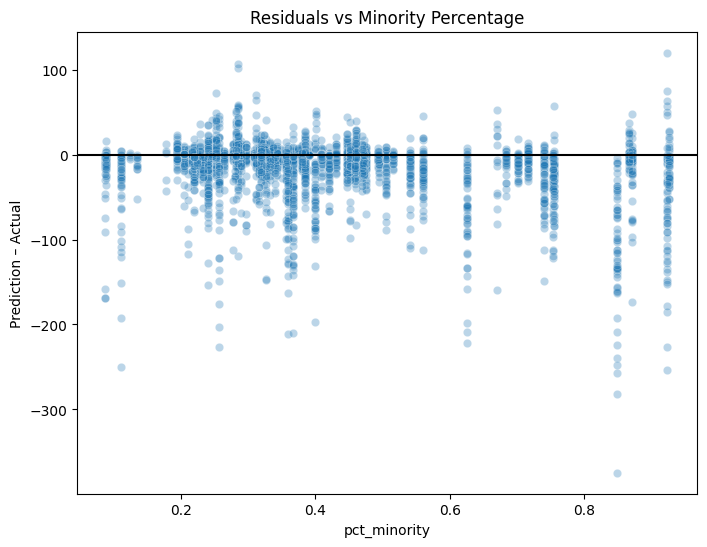

In [9]:
test['pred'] = preds
test['residual'] = test['pred'] - test['boardings']

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=test.sample(3000),   # downsample for plotting
    x='pct_minority',
    y='residual',
    alpha=0.3
)
plt.axhline(0, color='black')
plt.title("Residuals vs Minority Percentage")
plt.xlabel("pct_minority")
plt.ylabel("Prediction – Actual")
plt.show()


<Axes: xlabel='pct_minority', ylabel='residual'>

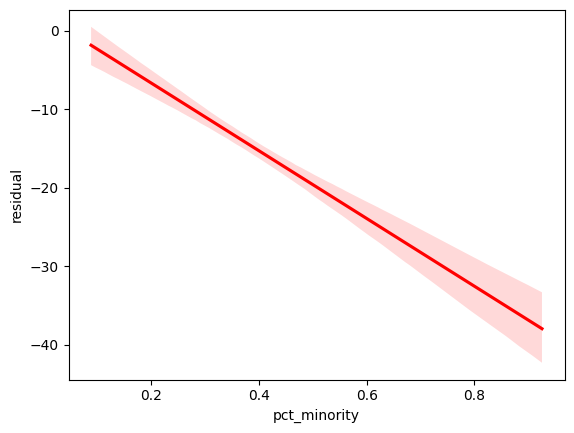

In [10]:
sns.regplot(
    data=test.sample(5000),
    x='pct_minority',
    y='residual',
    scatter=False,
    color='red'
)


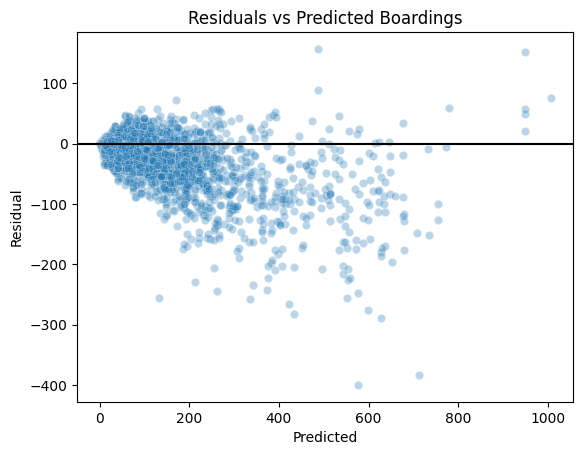

In [13]:
sns.scatterplot(data=test.sample(5000), x='pred', y='residual', alpha=0.3)
plt.axhline(0, color='black')
plt.title("Residuals vs Predicted Boardings")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()


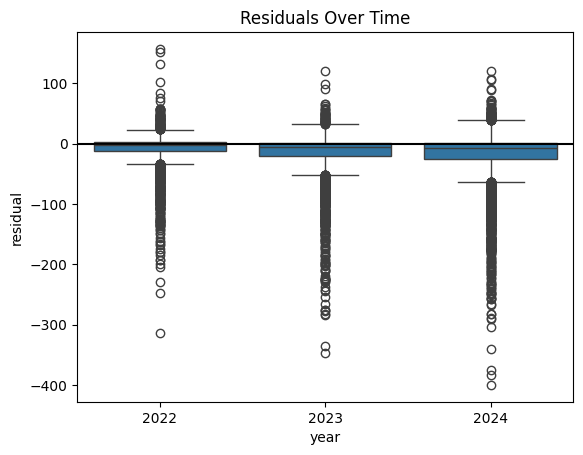

In [14]:
sns.boxplot(data=test, x='year', y='residual')
plt.axhline(0, color='black')
plt.title("Residuals Over Time")
plt.show()


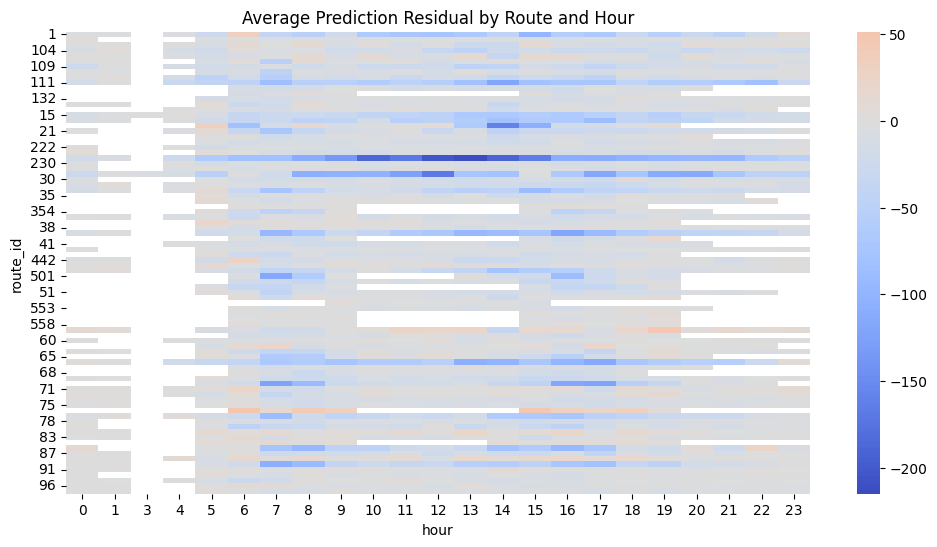

In [15]:
heat = test.pivot_table(
    index='route_id',
    columns='hour',
    values='residual',
    aggfunc='mean'
)

plt.figure(figsize=(12,6))
sns.heatmap(heat, cmap='coolwarm', center=0)
plt.title("Average Prediction Residual by Route and Hour")
plt.show()


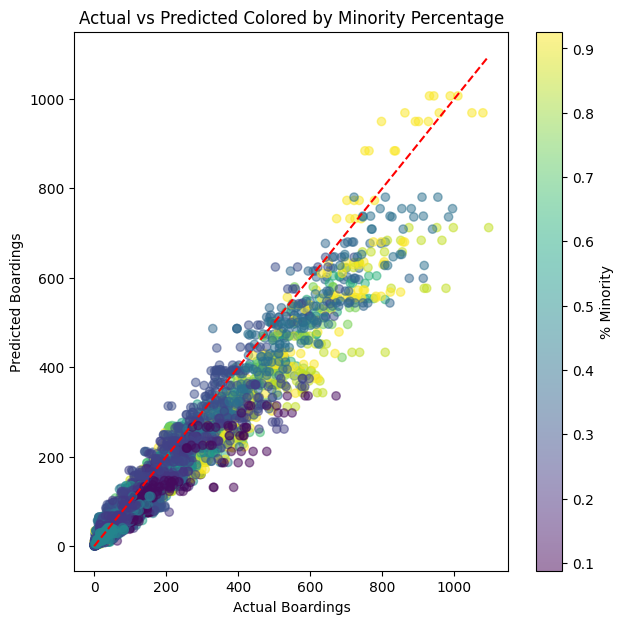

In [16]:
plt.figure(figsize=(7,7))
plt.scatter(
    test['boardings'],
    test['pred'],
    c=test['pct_minority'],
    cmap='viridis',
    alpha=0.5
)
plt.plot([0, test['boardings'].max()],
         [0, test['boardings'].max()],
         'r--')
plt.colorbar(label='% Minority')
plt.xlabel("Actual Boardings")
plt.ylabel("Predicted Boardings")
plt.title("Actual vs Predicted Colored by Minority Percentage")
plt.show()


In [17]:
test['minority_q'] = pd.qcut(test['pct_minority'], 4, labels=['Q1','Q2','Q3','Q4'])

test.groupby('minority_q')['residual'].mean()


/tmp/ipython-input-4283000601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['minority_q'] = pd.qcut(test['pct_minority'], 4, labels=['Q1','Q2','Q3','Q4'])
/tmp/ipython-input-4283000601.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test.groupby('minority_q')['residual'].mean()


,residual
minority_q,
Q1,-10.322331
Q2,-11.851096
Q3,-9.524204
Q4,-29.982300


In [ ]:
# Define underpredicted
test['underpred'] = (test['residual'] < -20).astype(int)


/tmp/ipython-input-3295713094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['underpred'] = (test['residual'] < -20).astype(int)


In [ ]:
# these are featuures for fairness model
fair_features = [
    "pct_minority",
    "pct_low_income",
    "pct_zero_vehicle",
    "pct_limited_english",
    "pct_youth",
    "pct_senior",
    "hour",
    "year",
    "day_type_name",
    "route_id"
]

from sklearn.model_selection import train_test_split

X_fair = test[fair_features]
y_fair = test["underpred"]

X_train_fair, X_val_fair, y_train_fair, y_val_fair = train_test_split(
    X_fair, y_fair, test_size=0.25, random_state=42, stratify=y_fair
)

In [ ]:
# categorical and numeric features for fairness model
categorical_fair = ["day_type_name", "route_id"]

numeric_fair = [
    "pct_minority", "pct_low_income", "pct_zero_vehicle",
    "pct_limited_english", "pct_youth", "pct_senior",
    "hour", "year"
]

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

fair_preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_fair),
        ("num", "passthrough", numeric_fair)
    ]
)


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

clf = Pipeline([
    ("prep", fair_preprocess),
    ("model", LogisticRegression(max_iter=500))
])


In [33]:
clf.fit(X_train_fair, y_train_fair)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['day_type_name',
                                                   'route_id']),
                                                 ('num', 'passthrough',
                                                  ['pct_minority',
                                                   'pct_low_income',
                                                   'pct_zero_vehicle',
                                                   'pct_limited_english',
                                                   'pct_youth', 'pct_senior',
                                                   'hour', 'year'])])),
                ('model', LogisticRegression(max_iter=500))])

In [34]:
pred_fair = clf.predict(X_val_fair)

[[2347  198]
 [ 460  377]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2545
           1       0.66      0.45      0.53       837

    accuracy                           0.81      3382
   macro avg       0.75      0.69      0.71      3382
weighted avg       0.79      0.81      0.79      3382



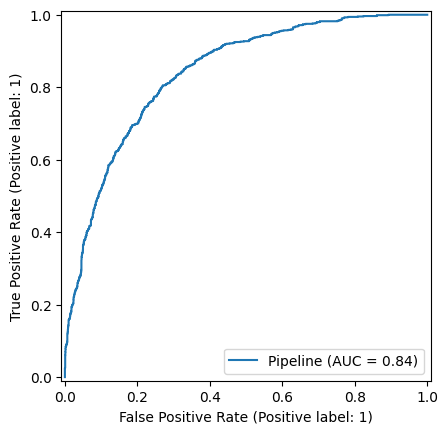

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay

print(confusion_matrix(y_val_fair, pred_fair))
print(classification_report(y_val_fair, pred_fair))

# display ROC curve
RocCurveDisplay.from_estimator(clf, X_val_fair, y_val_fair)
plt.show()
